# 2A.ml : Déterminer la vitesse moyenne des vélib

Ce notebook explicite la solution proposée pour la [coding party du 22 mai 2014](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/coding_party_1.html). L'enjeu était de calculer la vitesse moyenne des velib.

In [ ]:
%matplotlib inline

Même si je propose quelques jeux de données, il est possible de créer le sien en s'inspirant du code suivant : [Récupérer les données Velib et les visualiser](http://www.xavierdupre.fr/app/pyensae/helpsphinx/notebooks/pyensae_velib.html). Le premier lien décrit les données plus en détail : elles sont constituées des décomptes des vélos et places disponibles pour chaque station d'une même ville et pour chaque minute. La méthode proposée ici est celle des **appariements** décrites par le premier lien. L'algorithme peut être décrit en deux étapes :

1. Construction d'une base d'événements : vélos reposés et retirés.
2. Appariement des vélos retirés avec les vélos reposés.

La première partie ne pose pas de difficulté particulière. On peut juste penser à retirer les premiers vélos réposés qui ne pourront pas être appariés de toutes façons. On fait de même pour les derniers vélos retirés.

La seconde partie est constitutée de deux éléments :

- un coût d'appariement
- la minimisation de l'appariement

Pour le coût, on peut y mettre à peu près toutes les contraintes imaginables (vitesse trop grande, durée trop grande ou trop petite). Pour la seconde, le code optimise de façon très naïve : on part d'un appariement aléatoire, on tire deux appariements $a_1 \rightarrow b_1$ et $a_2 \rightarrow b_2$. On inverse : $a_1 \rightarrow b_2$ et $a_2 \rightarrow b_1$. Si l'appariement est moins coûteux, on garde.

Le code complet est disponible ici : [coding party 1](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/ensae_teaching_cs/coding_party/coding_party1_velib.html).

In [ ]:
import pyensae, pandas, pyquickhelper
from pyquickhelper.loghelper import str2datetime
from ensae_teaching_cs.data import besancon_df
jeu = besancon_df()
df = pandas.read_csv(jeu, sep="\t", encoding="utf8")
df ["collect_date"] = df.apply( lambda r: str2datetime(r["collect_date"]),axis=1)
df.head()

,address,available_bike_stands,available_bikes,banking,bike_stands,bonus,collect_date,contract_name,file,last_update,lat,lng,name,number,status
0,Place Jacobins,2,8,0,10,0,2014-05-22 02:40:03.954829,Besancon,velib_data.2014-05-22_02-40-02.681782.txt,2014-05-22 00:09:26,47.234142,6.033465,14 - JACOBINS,14,OPEN
1,"Rue Charles NODIER Sortie du tunnel, direction...",1,11,0,12,0,2014-05-22 02:40:03.954829,Besancon,velib_data.2014-05-22_02-40-02.681782.txt,2014-05-22 02:38:48,47.232098,6.035136,23 - RIVOTTE,23,OPEN
2,Avenue de la Gare d'Eau face Conseil Général,4,6,0,10,0,2014-05-22 02:40:03.954829,Besancon,velib_data.2014-05-22_02-40-02.681782.txt,2014-05-21 13:24:02,47.232140,6.022843,16 - GARE D'EAU,16,OPEN
3,18 rue Xavier Marmier,6,6,0,12,0,2014-05-22 02:40:03.954829,Besancon,velib_data.2014-05-22_02-40-02.681782.txt,2014-05-22 00:00:44,47.241256,6.006690,30 - XAVIER MARMIER,30,OPEN
4,Rue Battant (au niveau du Square Bouchot),1,9,0,10,0,2014-05-22 02:40:03.954829,Besancon,velib_data.2014-05-22_02-40-02.681782.txt,2014-05-22 02:31:01,47.242990,6.022070,02 - SQUARE BOUCHOT,2,OPEN


**On vérifie les données pour la première date :**

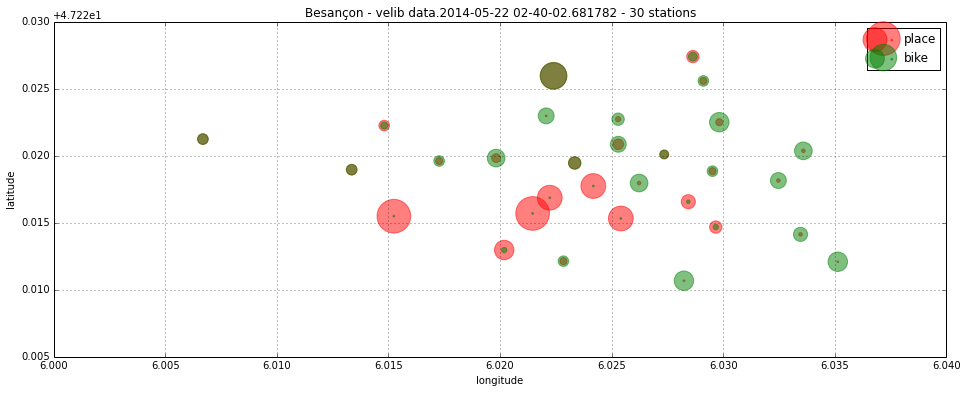

In [ ]:
from pyensae.datasource import DataVelibCollect
dt = df["file"][0]
subset = df [ df["file"] == dt ]
fig,ax,plt = DataVelibCollect.draw(subset, figsize=(16,6))
ax.set_title("Besançon - {0} - {1} stations".format(dt.replace("besancon.","").replace(".txt","").replace("_", " "), len(subset)))

**On calcule les événements (1 vélo apparu, 1 vélo disparu) :**

In [ ]:
import ensae_teaching_cs.coding_party.coding_party1_velib as velib
events = list(sorted(velib.enumerate_events(df)))
print("nb events",len(events))
events [:2]

nb events 589


[('velib_data.2014-05-22_04-17-04.635259.txt',
  Timestamp('2014-05-22 04:17:04.857260', tz=None),
  '24 - MEDIATHEQUE',
  47.24010992877723,
  6.027358757731063,
  1),
 ('velib_data.2014-05-22_05-29-04.949889.txt',
  Timestamp('2014-05-22 05:29:05.262905', tz=None),
  '27 - MAIRIE',
  47.23687885054159,
  6.0222303583977155,
  1)]

**On calcule le meilleur appariement (ça prend un peu de temps).** On ne prend que 200 itérations mais il en faudrait plus.

In [ ]:
params = velib.ParemetreCoutTrajet()
print(params)
mindist, moyenne, appariement, positif, negatif = velib.appariement(events, iter=200, params=params)
print("vitesse moyenne", moyenne)

{'low_time': 0.1, 'high_time': 0.75, 'high_speed': 25, 'max_speed': 50, 'low_speed': 5}
iteration  0 : app- 144 / 301 min 21743314023.08393 vitesse  5.185466030632195  nbchange 0
iteration  10 : app- 27 / 301 min 3500280071.4679384 vitesse  5.06270503323576  nbchange 265
iteration  20 : app- 17 / 301 min 2115655400.3662798 vitesse  5.563301600017276  nbchange 88
iteration  30 : app- 16 / 301 min 1848277952.4179378 vitesse  6.216448908101307  nbchange 61
iteration  40 : app- 12 / 301 min 1454443114.2767859 vitesse  6.3271201186859924  nbchange 49
iteration  50 : app- 11 / 301 min 1197231541.672908 vitesse  6.509489698366032  nbchange 37
iteration  60 : app- 11 / 301 min 1197225176.6057749 vitesse  6.604998730500649  nbchange 33
iteration  70 : app- 9 / 301 min 1070392823.3548737 vitesse  6.709849052929976  nbchange 35
iteration  80 : app- 9 / 301 min 944835041.01864 vitesse  6.738541347652123  nbchange 40
iteration  90 : app- 9 / 301 min 944831882.6248296 vitesse  6.731525948853118  nbc

La vitesse évolue encore et il faudrait faire tourner l'algorithme plus longtemps. Voyons déjà ce que cela donne en terme de déplacement.

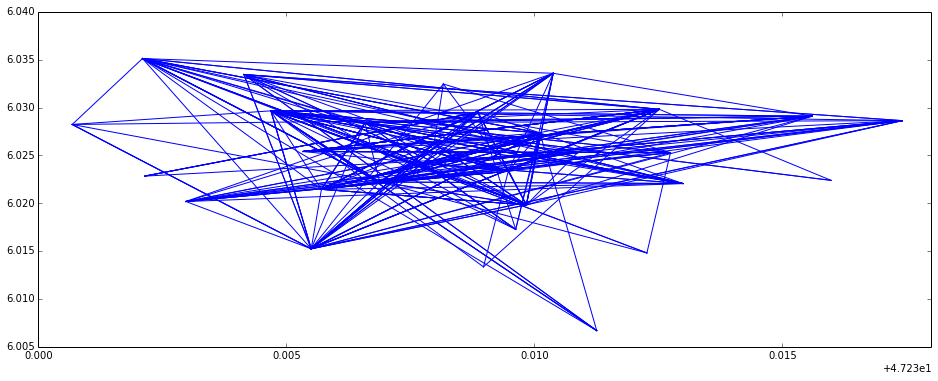

In [ ]:
import matplotlib.pyplot as plt
app =[  ( positif[a], negatif[b] ) for a,b in appariement ]
plt.figure(figsize=(16,6))
for deb,fin in app :
    x = [deb[3], fin[3]]
    y = [deb[4], fin[4]]
    if x[0] > 0 and y[0] and x[1] > 0 and y[1] > 0 :
        # on enlève les trajets aberrants
        plt.plot(x,y,color="b")

Difficle de dire sur ce simple dessin si cela est sensé. Je continuerai plus tard et en faisant tourner cela plus longtemps.